In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# manually add several records to infer power based on metrics
# input data records:
# - rider weight
# - bike weight
# - air resistance (C_d)

In [44]:
df_sheets = pd.read_excel("zwift_bike_data.xlsx", sheet_name=None)

df = pd.concat([v for v in df_sheets.values()], ignore_index=True)
df = df.drop(df.columns[0], axis = 1)
df["grade"] = df["grade"].str.replace("%", "").astype(float)

df.shape

(2400, 7)

In [29]:
df.head(2)

,bike_wheel_weight,Air_resistance_(Cd),weight,height,power,grade,speed
0,6.781,0.8391,65.0,170.0,100.0,-12.0,94.81
1,6.781,0.8391,65.0,170.0,100.0,-11.0,90.71


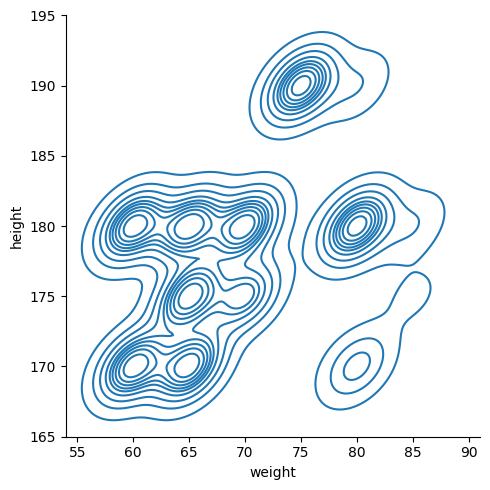

In [45]:
sns.displot(df, x="weight", y="height", kind="kde")

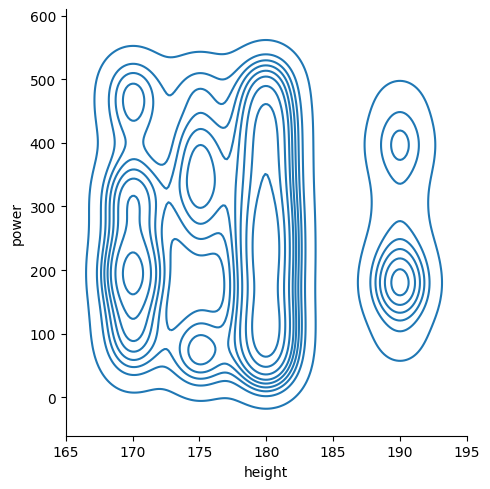

In [46]:
sns.displot(df, x="height", y="power", kind="kde")

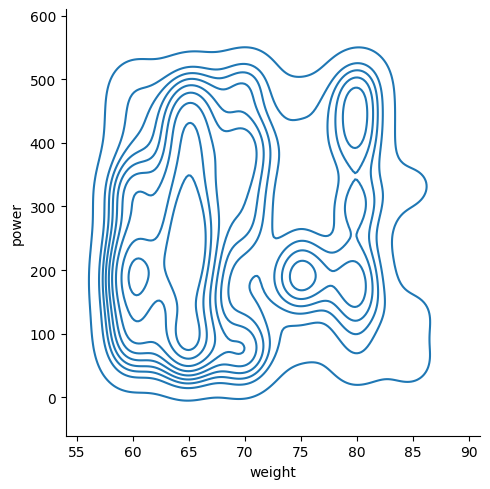

In [48]:
sns.displot(df, x="weight", y="power", kind="kde")

In [8]:
df[(df["weight"] == 80) & (df["height"] == 180)]["power"].value_counts().sort_index()

power
50     25
100    25
150    25
200    25
250    25
300    25
350    25
400    25
450    25
500    25
Name: count, dtype: int64

In [49]:
pd.crosstab(df["weight"], df["height"])

height,170,175,180,190
weight,,,,
60,250,0,250,0
65,250,250,250,0
70,0,175,250,0
75,0,0,0,250
80,100,0,250,50
85,0,25,50,0


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [25]:
def cross_val_tree_pruning(X_train, y_train):
    d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
    d3.fit(X_train, y_train)
    print("Tree Train RMSE: {:.4f}\n".format((mean_squared_error(y_train, d3.predict(X_train)))))

    # Compute impurities to look for an adequate pruning term
    path = d3.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # Plot the impurity level given ccp_alpha
    # plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
    # plt.xlabel("effective alpha")
    # plt.ylabel("total impurity of leaves")
    # plt.title("Total Impurity vs effective alpha for training set")
    # plt.show()

    # Tree Pruning (we are overfitting - Accuracy: 100% in training)
    tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                                for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                        num = 5)]}

    tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                            tree_params, cv = 3, n_jobs = 6, verbose = 10,
                            return_train_score = True)
    tree_grid.fit(X_train, y_train)

    return tree_grid.best_estimator_

In [ ]:
# drop additional columns since now they are constant
X = df.drop("power", axis = 1).drop(["bike_wheel_weight",
                                     "Air_resistance_(Cd)"
                                     ], axis = 1)
y = df["power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)


tree_model = cross_val_tree_pruning(X_train, y_train)


lr = LinearRegression()
lr.fit(X_train, y_train)
# --------------------------
print("*** Tree ***")
print("MSE: %.2f" % mean_squared_error(tree_model.predict(X_test), y_test))
print("MAE: %.2f" % mean_absolute_error(tree_model.predict(X_test), y_test))
print("MAPE: %.2f %s" % (100*(mean_absolute_percentage_error(tree_model.predict(X_test), y_test)), "%"))

print("*** LR ***")
print("MSE: %.2f" % mean_squared_error(lr.predict(X_test), y_test))
print("MAE: %.2f" % mean_absolute_error(lr.predict(X_test), y_test))
print("MAPE: %.2f %s" % (100*(mean_absolute_percentage_error(lr.predict(X_test), y_test)), "%"))

Tree Train RMSE: 0.0000

Fitting 3 folds for each of 5 candidates, totalling 15 fits
*** Tree ***
MSE: 4555.24
MAE: 43.01
MAPE: 22.14 %
*** LR ***
MSE: 11582.45
MAE: 88.00
MAPE: 38.69 %


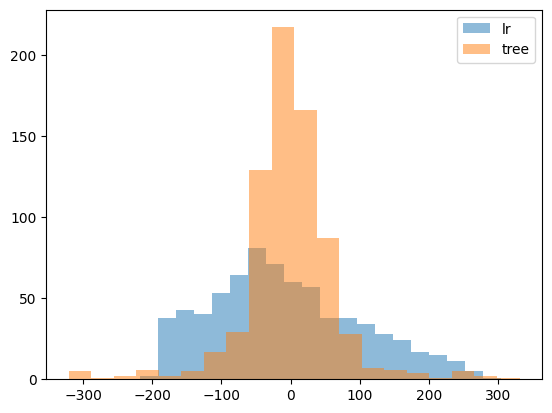

In [68]:
plt.hist(lr.predict(X_test) - y_test, label = "lr", alpha = .5, bins=20)
plt.hist(tree_model.predict(X_test) - y_test, label = "tree", alpha = .5, bins=20)
plt.legend()
plt.show()